<a href="https://colab.research.google.com/github/luciacasass/UFV-VisualizacionDatos/blob/main/EjerciciosClase/Clase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualización de Datos

Lucía Casas Sierra

In [11]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

warnings.filterwarnings("ignore")

# Carga de datos
df = pd.read_csv('datos_ejercicio_ventas.csv')
print(df.head())

countries = df['COUNTRY'].unique()
brands = df['SUBBRAND'].unique()

df['DATE'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str) + '-01')
date_range_actual = [df['DATE'][df['SCENARIO']=='actual'].dt.date.min().strftime('%Y-%m'),
                     df['DATE'][df['SCENARIO']=='actual'].dt.date.max().strftime('%Y-%m')]
date_range_forecast = [df['DATE'][df['SCENARIO']=='AI_forecast'].dt.date.min().strftime('%Y-%m'),
                       df['DATE'][df['SCENARIO']=='AI_forecast'].dt.date.max().strftime('%Y-%m')]

print('\nLista de países:\n', countries)
print('\nLista de marcas:\n', brands)
print()
print('Espacio temporal para datos reales de ventas: ', date_range_actual)
print('Espacio temporal para predicciones de ventas: ', date_range_forecast)

         COUNTRY        SUBBRAND  YEAR  MONTH     SCENARIO FORECAST  \
0       Portugal     Lipton (L3)  2023     12  AI_forecast  AI_P02F   
1  Great Britain     Lipton (L3)  2023     12  AI_forecast  AI_P10F   
2          Spain  Pepsi Max (L3)  2023     12  AI_forecast  AI_P09F   
3  Great Britain        7up (L3)  2024     12  AI_forecast  AI_P10F   
4        Hungary     Lipton (L3)  2023      9  AI_forecast  AI_P03F   

   FORECAST_YEAR         AMOUNT  
0         2023.0  754356.237194  
1         2023.0  560030.558029  
2         2023.0   88501.980847  
3         2023.0  363224.511516  
4         2023.0  396176.120491  

Lista de países:
 ['Portugal' 'Great Britain' 'Spain' 'Hungary' 'Norway' 'Denmark'
 'Netherlands' 'Italy' 'Czech']

Lista de marcas:
 ['Lipton (L3)' 'Pepsi Max (L3)' '7up (L3)' 'Pepsi Regular (L3)'
 'Mountain Dew (L3)' '7up Free (L3)']

Espacio temporal para datos reales de ventas:  ['2023-01', '2024-08']
Espacio temporal para predicciones de ventas:  ['2023-01', '2

In [12]:
df_actual = df[df['SCENARIO'] == 'actual']
df_forecast = df[df['SCENARIO'] == 'AI_forecast']

print('VENTAS REALES:')
print('Número de filas: ', len(df_actual))
print(f'Representa el {(len(df_actual)/len(df)*100):.2f}% del archivo original')

print('\nDATOS DE PRONÓSTICO:')
print('Número de filas: ', len(df_forecast))
print(f'Representa el {(len(df_forecast)/len(df)*100):.2f}% del archivo original')

VENTAS REALES:
Número de filas:  900
Representa el 4.82% del archivo original

DATOS DE PRONÓSTICO:
Número de filas:  17766
Representa el 95.18% del archivo original


In [16]:
# Horizontes de predicción
df_forecast['FORECAST_MONTH'] = pd.to_numeric(df_forecast['FORECAST'].str.extract('-(\d+)')[0])
df_forecast['FORECAST_MONTH'] = df_forecast['FORECAST_MONTH'].fillna(1).astype(int)
df_forecast['FORECAST_YEAR'] = df_forecast['FORECAST_YEAR'].astype(int)

df_forecast['FORECAST_DATE'] = pd.to_datetime(
    df_forecast['FORECAST_YEAR'].astype(str) + '-' +
    df_forecast['FORECAST_MONTH'].astype(str) + '-01'
)
# De acuerdo al conocimiento de la base de datos, se resta un mes
df_forecast['FORECAST_DATE'] = df_forecast['FORECAST_DATE'] - pd.DateOffset(months=1)

df_forecast['HORIZON_MONTHS'] = (
    (df_forecast['DATE'].dt.year - df_forecast['FORECAST_DATE'].dt.year) * 12
    + (df_forecast['DATE'].dt.month - df_forecast['FORECAST_DATE'].dt.month)
)

print(df_forecast.head())

subbrand_horizon_months = df_forecast.groupby('SUBBRAND')['HORIZON_MONTHS'].max().reset_index()
print(subbrand_horizon_months.to_string(index=False))

         COUNTRY        SUBBRAND  YEAR  MONTH     SCENARIO FORECAST  \
0       Portugal     Lipton (L3)  2023     12  AI_forecast  AI_P02F   
1  Great Britain     Lipton (L3)  2023     12  AI_forecast  AI_P10F   
2          Spain  Pepsi Max (L3)  2023     12  AI_forecast  AI_P09F   
3  Great Britain        7up (L3)  2024     12  AI_forecast  AI_P10F   
4        Hungary     Lipton (L3)  2023      9  AI_forecast  AI_P03F   

   FORECAST_YEAR         AMOUNT       DATE  FORECAST_MONTH FORECAST_DATE  \
0           2023  754356.237194 2023-12-01               1    2022-12-01   
1           2023  560030.558029 2023-12-01               1    2022-12-01   
2           2023   88501.980847 2023-12-01               1    2022-12-01   
3           2023  363224.511516 2024-12-01               1    2022-12-01   
4           2023  396176.120491 2023-09-01               1    2022-12-01   

   HORIZON_MONTHS  
0              12  
1              12  
2              12  
3              24  
4               

### Distribución de ventas reales
#### Por país

In [31]:

sales_by_country = df_actual.groupby('COUNTRY')['AMOUNT'].sum().reset_index()
sales_by_country.columns = ['COUNTRY', 'TOTAL_SALES']

# Create a bar graph using Plotly Express
fig = px.bar(
    sales_by_country,
    x='COUNTRY',
    y='TOTAL_SALES',
    color_discrete_sequence=['#489fb5'],
    title='Total Sales by Country'
)

# Show the plot
fig.show()

#### Por mes y año

In [32]:
sales_by_month_year = df_actual.groupby(['YEAR', 'MONTH'])['AMOUNT'].sum().reset_index()

# Rename the columns for clarity
sales_by_month_year.columns = ['YEAR', 'MONTH', 'TOTAL_SALES']

# Create a new column for easy display of month and year together (optional, for better labeling)
sales_by_month_year['YEAR_MONTH'] = sales_by_month_year['YEAR'].astype(str) + '-' + sales_by_month_year['MONTH'].astype(str).str.zfill(2)

# Create a bar graph using Plotly Express
fig = px.bar(
    sales_by_month_year,
    x='YEAR_MONTH',  # Use the year-month for the x-axis
    y='TOTAL_SALES',
    color_discrete_sequence=['#489fb5'],
    title='Total Sales by Year and Month',
    barmode='group',  # Group the bars by country for each year-month
    height=600  # Adjust height for better readability
)

# Customize axis labels for better readability
fig.update_layout(
    xaxis_title='Year-Month',
    yaxis_title='Total Sales'
)

# Show the plot
fig.show()

#### Por marca

In [33]:
sales_by_subbrand = df_actual.groupby('SUBBRAND')['AMOUNT'].sum().reset_index()
sales_by_subbrand.columns = ['SUBBRAND', 'TOTAL_SALES']

# Create a bar graph using Plotly Express
fig = px.bar(
    sales_by_subbrand,
    x='SUBBRAND',
    y='TOTAL_SALES',
    color_discrete_sequence=['#489fb5'],
    title='Total Sales by SubBrand'
)

# Show the plot
fig.show()

### Tendencia y estacionalidad
#### Todas las ventas del país con menos ventas

In [34]:
# Identificación del país con menor número de ventas
min_sales_country = sales_by_country.loc[sales_by_country['TOTAL_SALES'].idxmin(), 'COUNTRY']
print('País con menor número de ventas: ', min_sales_country)

País con menor número de ventas:  Spain


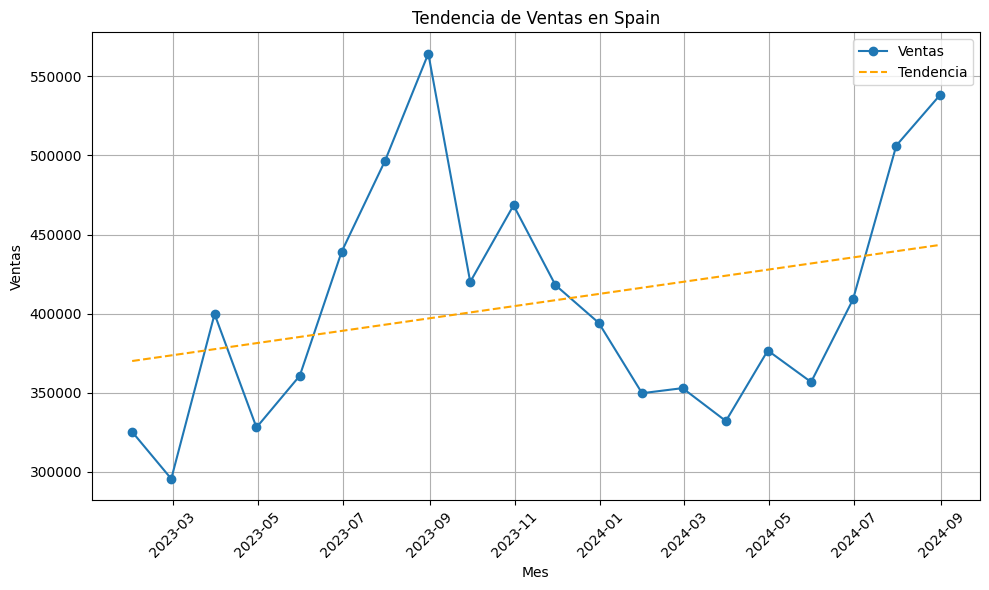

In [42]:
import numpy as np

sales_by_country_month = df_actual.groupby(['COUNTRY', pd.Grouper(key='DATE', freq='M')])['AMOUNT'].sum().reset_index()
sales_by_country_month.columns = ['COUNTRY', 'DATE', 'TOTAL_SALES']

# Filtrar por el país con ventas mínimas (asegúrate de que min_sales_country esté definido)
country_data = sales_by_country_month[sales_by_country_month['COUNTRY'] == min_sales_country]

# Convertir las fechas a un formato numérico (timestamp)
country_data['DATE_NUM'] = country_data['DATE'].map(pd.Timestamp.timestamp)

# Realizar la regresión lineal
coef = np.polyfit(country_data['DATE_NUM'], country_data['TOTAL_SALES'], 1)
polynomial = np.poly1d(coef)

# Calcular las tendencias
country_data['TENDENCIA'] = polynomial(country_data['DATE_NUM'])

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(country_data['DATE'], country_data['TOTAL_SALES'], label='Ventas', marker='o')
plt.plot(country_data['DATE'], country_data['TENDENCIA'], label='Tendencia', linestyle='--', color='orange')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.title(f'Tendencia de Ventas en {min_sales_country}')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### La marca con más ventas

In [35]:
# Identificación del país con mayor número de ventas
max_sales_country = sales_by_country.loc[sales_by_country['TOTAL_SALES'].idxmax(), 'COUNTRY']
print('País con mayor número de ventas: ', max_sales_country)

País con mayor número de ventas:  Great Britain


### Predicciones España y evaluación de la bondad

In [51]:
forecast_spain = df_forecast[df_forecast['COUNTRY'] == 'Spain']
# Extraer las predicciones más cercanas a cada uno de los meses
# idx = forecast_spain.groupby('DATE')['HORIZON_MONTHS'].idxmin()

# # Extraer las filas correspondientes a esos índices
# forecast_spain = forecast_spain.loc[idx].reset_index(drop=True)

actual_spain = df_actual[df_actual['COUNTRY'] == 'Spain']

In [55]:
set1 = set(actual_spain['DATE'].unique())
set2 = set(forecast_spain['DATE'].unique())

# Encontrar diferencias
solo_en_lista1 = set1 - set2  # Elementos en lista1 que no están en lista2
solo_en_lista2 = set2 - set1  # Elementos en lista2 que no están en lista1

print("Elementos solo en lista1:", solo_en_lista1)
print("Elementos solo en lista2:", solo_en_lista2)

Elementos solo en lista1: set()
Elementos solo en lista2: {Timestamp('2025-03-01 00:00:00'), Timestamp('2024-11-01 00:00:00'), Timestamp('2024-10-01 00:00:00'), Timestamp('2024-12-01 00:00:00'), Timestamp('2024-09-01 00:00:00'), Timestamp('2025-02-01 00:00:00'), Timestamp('2025-04-01 00:00:00'), Timestamp('2025-01-01 00:00:00'), Timestamp('2025-05-01 00:00:00')}


Las fechas son iguales.


ConversionError: Failed to convert value(s) to axis units: 2370    2023-04-01
2884    2023-01-01
5073    2024-05-01
6018    2024-03-01
7118    2023-10-01
7751    2024-02-01
8676    2023-05-01
9213    2024-08-01
11346   2023-07-01
11642   2023-09-01
12197   2023-03-01
12343   2024-01-01
13846   2023-11-01
13975   2023-12-01
14139   2024-06-01
15942   2023-06-01
17244   2024-04-01
17245   2024-07-01
17789   2023-08-01
18535   2023-02-01
Name: DATE, dtype: datetime64[ns]

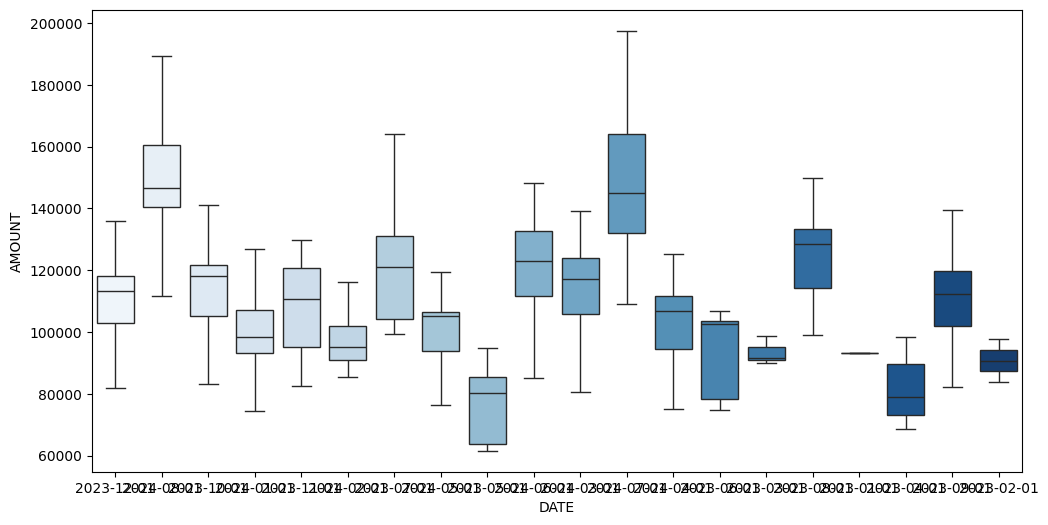

In [71]:
# Unir los datos de predicciones y reales en un solo DataFrame
combined_data = forecast_spain[forecast_spain['DATE'].isin(actual_spain['DATE'])].reset_index(drop=True)

for brand in combined_data['SUBBRAND'].unique():
    # Filtrar los datos para la marca actual
    brand_data = combined_data[combined_data['SUBBRAND'] == brand]

    # Configurar el tamaño de la figura
    plt.figure(figsize=(12, 6))

    # Crear el boxplot para las predicciones
    sns.boxplot(x='DATE', y='AMOUNT', data=brand_data, palette='Blues', showfliers=False)

    # Graficar los valores reales como puntos
    plt.scatter(actual_spain['DATE'][actual_spain['SUBBRAND']==brand], actual_spain['AMOUNT'][actual_spain['SUBBRAND']==brand], color='red', label='Actual', marker='o')

    # Configurar etiquetas y título
    plt.xlabel('Mes')
    plt.ylabel('Ventas')
    plt.title(f'Comparación de Predicciones y Valores Reales para {brand}')
    plt.xticks(rotation=45)

    # Añadir leyenda y cuadrícula
    plt.legend()
    plt.grid()

    # Ajustar el diseño y mostrar el gráfico
    plt.tight_layout()
    plt.show()

In [69]:
for brand in actual_spain['SUBBRAND'].unique():
  dd = actual_spain[actual_spain['SUBBRAND'] == brand]
  duplicados = dd['DATE'].duplicated().sum()
  print("Número de fechas duplicadas:", duplicados)

Número de fechas duplicadas: 0
Número de fechas duplicadas: 0
Número de fechas duplicadas: 0
Número de fechas duplicadas: 0
Número de fechas duplicadas: 0
